# Predicting loan failure

This dataset contains [Lending Club's](http://lendingclub.com/) data from the 2015-2016 period and tries to predict the chance of default based on the data provided. Although the final accuracy reaches ~99.99% accuracy, it should be noted that identifying failing loans and predicting failing loans are not the same, so trust on scoring a similar rate of accuracy on future data is misplaced. I hope this is an interesting read that is clearly demonstrating the data analysis pipeline. If you have any comments, questions, or suggestion, I'd love to hear them!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display # learer display of pandas tables upon printing
from warnings import filterwarnings
import seaborn as sns

In [2]:
# Silence (deprecation) warnings
filterwarnings("ignore")

In [3]:
df = pd.read_excel("LoadData15_16.xlsx")

In [4]:
df.head()

,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount
0,25000,36 months,0.0749,777.55,Sales Manager,10+ years,MORTGAGE,109000.0,Not Verified,42339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23975,60 months,0.1989,633.73,Principal,10+ years,RENT,70000.0,Not Verified,42339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7200,36 months,0.1148,237.36,Legal Administrative Assistant,10+ years,MORTGAGE,72500.0,Verified,42339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21875,36 months,0.1199,726.46,Wire Technician,< 1 year,RENT,47590.0,Source Verified,42339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20000,36 months,0.1288,672.73,President,10+ years,MORTGAGE,145000.0,Not Verified,42339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
n_variables = df.shape[1]

In [6]:
len(df)

345941

## Data cleaning

### Drop columns with too many missing values

If more than 60% of the values are missing, drop the column. This has dropped 41 columns. Depending on how the analysis goes this may be revised at later stages but it is a good measure for now. There appear to be two "clusters" of missing values, those with ~21-24k (about 65%) and those with almost all the values missing (like desc, >99%).

In [7]:
threshold = 0.6 * len(df)

for col in df.columns:
    nulls = sum(df[col].isnull())
    if nulls > threshold:
        print(col, nulls)
        df.drop(col, axis=1, inplace=True)

url 345941
desc 345905
mths_since_last_record 284480
mths_since_last_major_derog 246767
annual_inc_joint 343557
dti_joint 343561
verification_status_joint 343557
open_acc_6m 212859
open_il_6m 212859
open_il_12m 212859
open_il_24m 212859
mths_since_rcnt_il 216444
total_bal_il 212859
il_util 230911
open_rv_12m 212859
open_rv_24m 212859
max_bal_bc 212859
all_util 212863
inq_fi 212859
total_cu_tl 212859
inq_last_12m 212859
mths_since_recent_bc_dlq 257953
mths_since_recent_revol_delinq 221999
sec_app_inq_last_6mths 345941
sec_app_mort_acc 345941
sec_app_open_il_6m 345941
sec_app_chargeoff_within_12_mths 345941
hardship_type 345790
hardship_reason 345790
hardship_status 345790
deferral_term 345790
hardship_amount 345790
hardship_start_date 345790
hardship_end_date 345790
payment_plan_start_date 345790
hardship_length 345790
hardship_dpd 345790
hardship_loan_status 345790
orig_projected_additional_accrued_interest 345826
hardship_payoff_balance_amount 345790
hardship_last_payment_amount 34579

### Drop columns that have no variation or seem less useful

* Two columns appear to have only 1 value. These offer no insights so they are dropped.
* Drop ZIP values. They may serve as a proxy variable but for now I am removing them
* I will also drop State as a variable. These may potentially be useful, but due to dimentionality (would have to get a 50-level dummy variable) I'm discarding them

In [8]:
no_predictive_power = df.nunique()[df.nunique() == 1]
no_predictive_power

pymnt_plan     1
policy_code    1
dtype: int64

In [9]:
df.drop(no_predictive_power.keys(), axis=1, inplace=True)

In [10]:
df.drop('zip_code', axis=1, inplace=True)
df.drop('addr_state', axis=1, inplace=True)

### Review current columns

In [11]:
list_cols = list(df.columns)
print("Columns left: {}\nColumns dropped so far: {}".format(len(list_cols), 
                                                            n_variables-len(list_cols)))

Columns left: 79
Columns dropped so far: 45


In [12]:
# Check the columns and their data types
# Next step is to convert anything non-numeric to numeric
df.dtypes

loan_amnt                       int64
term                           object
int_rate                      float64
installment                   float64
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                         int64
loan_status                    object
purpose                        object
title                          object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line                int64
inq_last_6mths                  int64
mths_since_last_delinq        float64
open_acc                        int64
pub_rec                         int64
revol_bal                       int64
revol_util                    float64
total_acc                       int64
initial_list_status            object
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt 

### Convert strings to numerical values

Strings that needed reformatting (i.e. strings to numeric):
    
    term, emp_length

Strings that needed transformation (i.e. dummy/categorical variables):

    home_ownership, verification_status, loan_status, purpose, 
    title, initial_list_status, application_type, hardship_flag
    
**Categoricals with K different values will get K dummy variables.*

#### Categoricals --> Dummies

In [13]:
columns = "home_ownership, verification_status, loan_status, purpose, title, initial_list_status, \
application_type, hardship_flag".split(", ")
columns

['home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'title',
 'initial_list_status',
 'application_type',
 'hardship_flag']

In [14]:
df = pd.get_dummies(data=df, columns=columns)

print("Current number of columns:", df.shape[1])

Current number of columns: 126


#### Term

"The number of payments on the loan. Values are in months and can be either 36 or 60."

    Original format: "X months"
    Output format: X

In [15]:
df['term'] = df['term'].apply(lambda x: int(x[:3]))

#### Emp_length

"Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years."

    Original format: "10+ years"
    Output format: 10
    
    Original format: "<1 year"
    Output format: 0.5

    Original format: "2 years"
    Output format: 2
    

In [16]:
emp = df['emp_length'].copy() # Copy & rename for ease of use

# Replace strings with regular expressions
emp = emp.str.replace("\+? [years]+", "")
emp = emp.str.replace("< 1", "0.5")

# Number of missing values. These were not previously identified because 
# they were coded as strings. Since they are only 20,870 we can safely 
# ignore them. Here I will replace them with the average value of the 
# column, a standard practice for missing values.
print("Missing values:", sum(emp == 'n/a'))

# Convert non NaN to floats and get their mean value
mean_emp = np.mean(emp[emp != 'n/a'].astype(float))
print(f"Mean employment length in years: {mean_emp:.2f}")

# Replace NaNs with the mean
emp[emp=='n/a'] = mean_emp
# Put these values back into the DataFrame
df['emp_length'] = emp.astype(float)
# Reclaim memory
emp = None

Missing values: 20870
Mean employment length in years: 6.08


#### Non-convertible columns: emp_title

There are 101,979 different titles, which of course cannot be handled efficiently, nor can they be turned into a categorical or integer value. Ideally, these should be put into super-categories but that is not possible here.

In [17]:
df['emp_title'].nunique()

101979

In [18]:
df.drop('emp_title', axis=1, inplace=True)

### Format data into independent and dependent variables

I will model the chance that a loan belongs either in the "Charged Off" or in "Default" categories (hereafter any mention of default will refer to these) versus the chance that it belongs in the "Fully paid". This is achieved below via masking and boolean operations. The resulting Y vector has value 0 if the loan defaulted, 1 if it was paid fully.

In [19]:
loan_status = df.loc[:, df.columns.str.startswith('loan_status')]
loan_status.head()

,loan_status_Charged Off,loan_status_Current,loan_status_Default,loan_status_Fully Paid
0,0,0,0,1
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [20]:
loan_status.sum()

loan_status_Charged Off     35682
loan_status_Current        208906
loan_status_Default             8
loan_status_Fully Paid     101345
dtype: int64

In [21]:
# preserve original dataframe
X = df[df['loan_status_Current']==0].copy()

# boolean masking (explained above)
Y = 1 * (X['loan_status_Fully Paid']==1)

# drop dependent variable columns from X
X.drop(df.columns[df.columns.str.startswith('loan_status')], axis=1, inplace=True) 

In [22]:
print("Total cases:", len(Y))
print("Total predictors:", X.shape[1])
print("Baseline default rate: {:.2f}%".format(sum(Y)/len(Y)*100))

Total cases: 137035
Total predictors: 121
Baseline default rate: 73.96%


### Missing values

In [23]:
np.sum(X.isnull())[np.sum(X.isnull()) > 0]

dti                            5
mths_since_last_delinq     66184
revol_util                    59
last_pymnt_d                 318
next_pymnt_d              137027
last_credit_pull_d             1
bc_open_to_buy              1483
bc_util                     1570
mo_sin_old_il_acct          3311
mths_since_recent_bc        1411
mths_since_recent_inq      11375
num_rev_accts                  1
num_tl_120dpd_2m            6437
percent_bc_gt_75            1549
dtype: int64

#### next_pymnt_d

This column has >99% missing values so I'm dropping it.

In [24]:
X.drop('next_pymnt_d', axis=1, inplace=True)

#### mths_since_last_delinq

This column has ~66k missing values. I'm using the mean of the column to fill it. An alternative might be to fill with 0, or even drop it.

In [25]:
X["mths_since_last_delinq"].fillna(np.mean(X["mths_since_last_delinq"]), inplace=True)

#### Rest of the columns

Just filled with the column mean

In [26]:
for column in np.sum(X.isnull())[np.sum(X.isnull()) > 0].keys():
    X[column].fillna(np.mean(X[column]), inplace=True)

## Visualization 

Visualization of highest correlated variables with the response variable

In [27]:
# Joining them just 
new_X = X.join(Y)

# Correlation of all variables
cors = new_X.corr()
# Correlation of X variables with Y
corr_with_Y = cors["loan_status_Fully Paid"]
# select variables that have strong correlation with Y
corr_with_Y = corr_with_Y[(corr_with_Y>0.15) | (corr_with_Y<-0.15)]

# Turn these into columns
cols = [col for col in cors.columns if col in corr_with_Y]

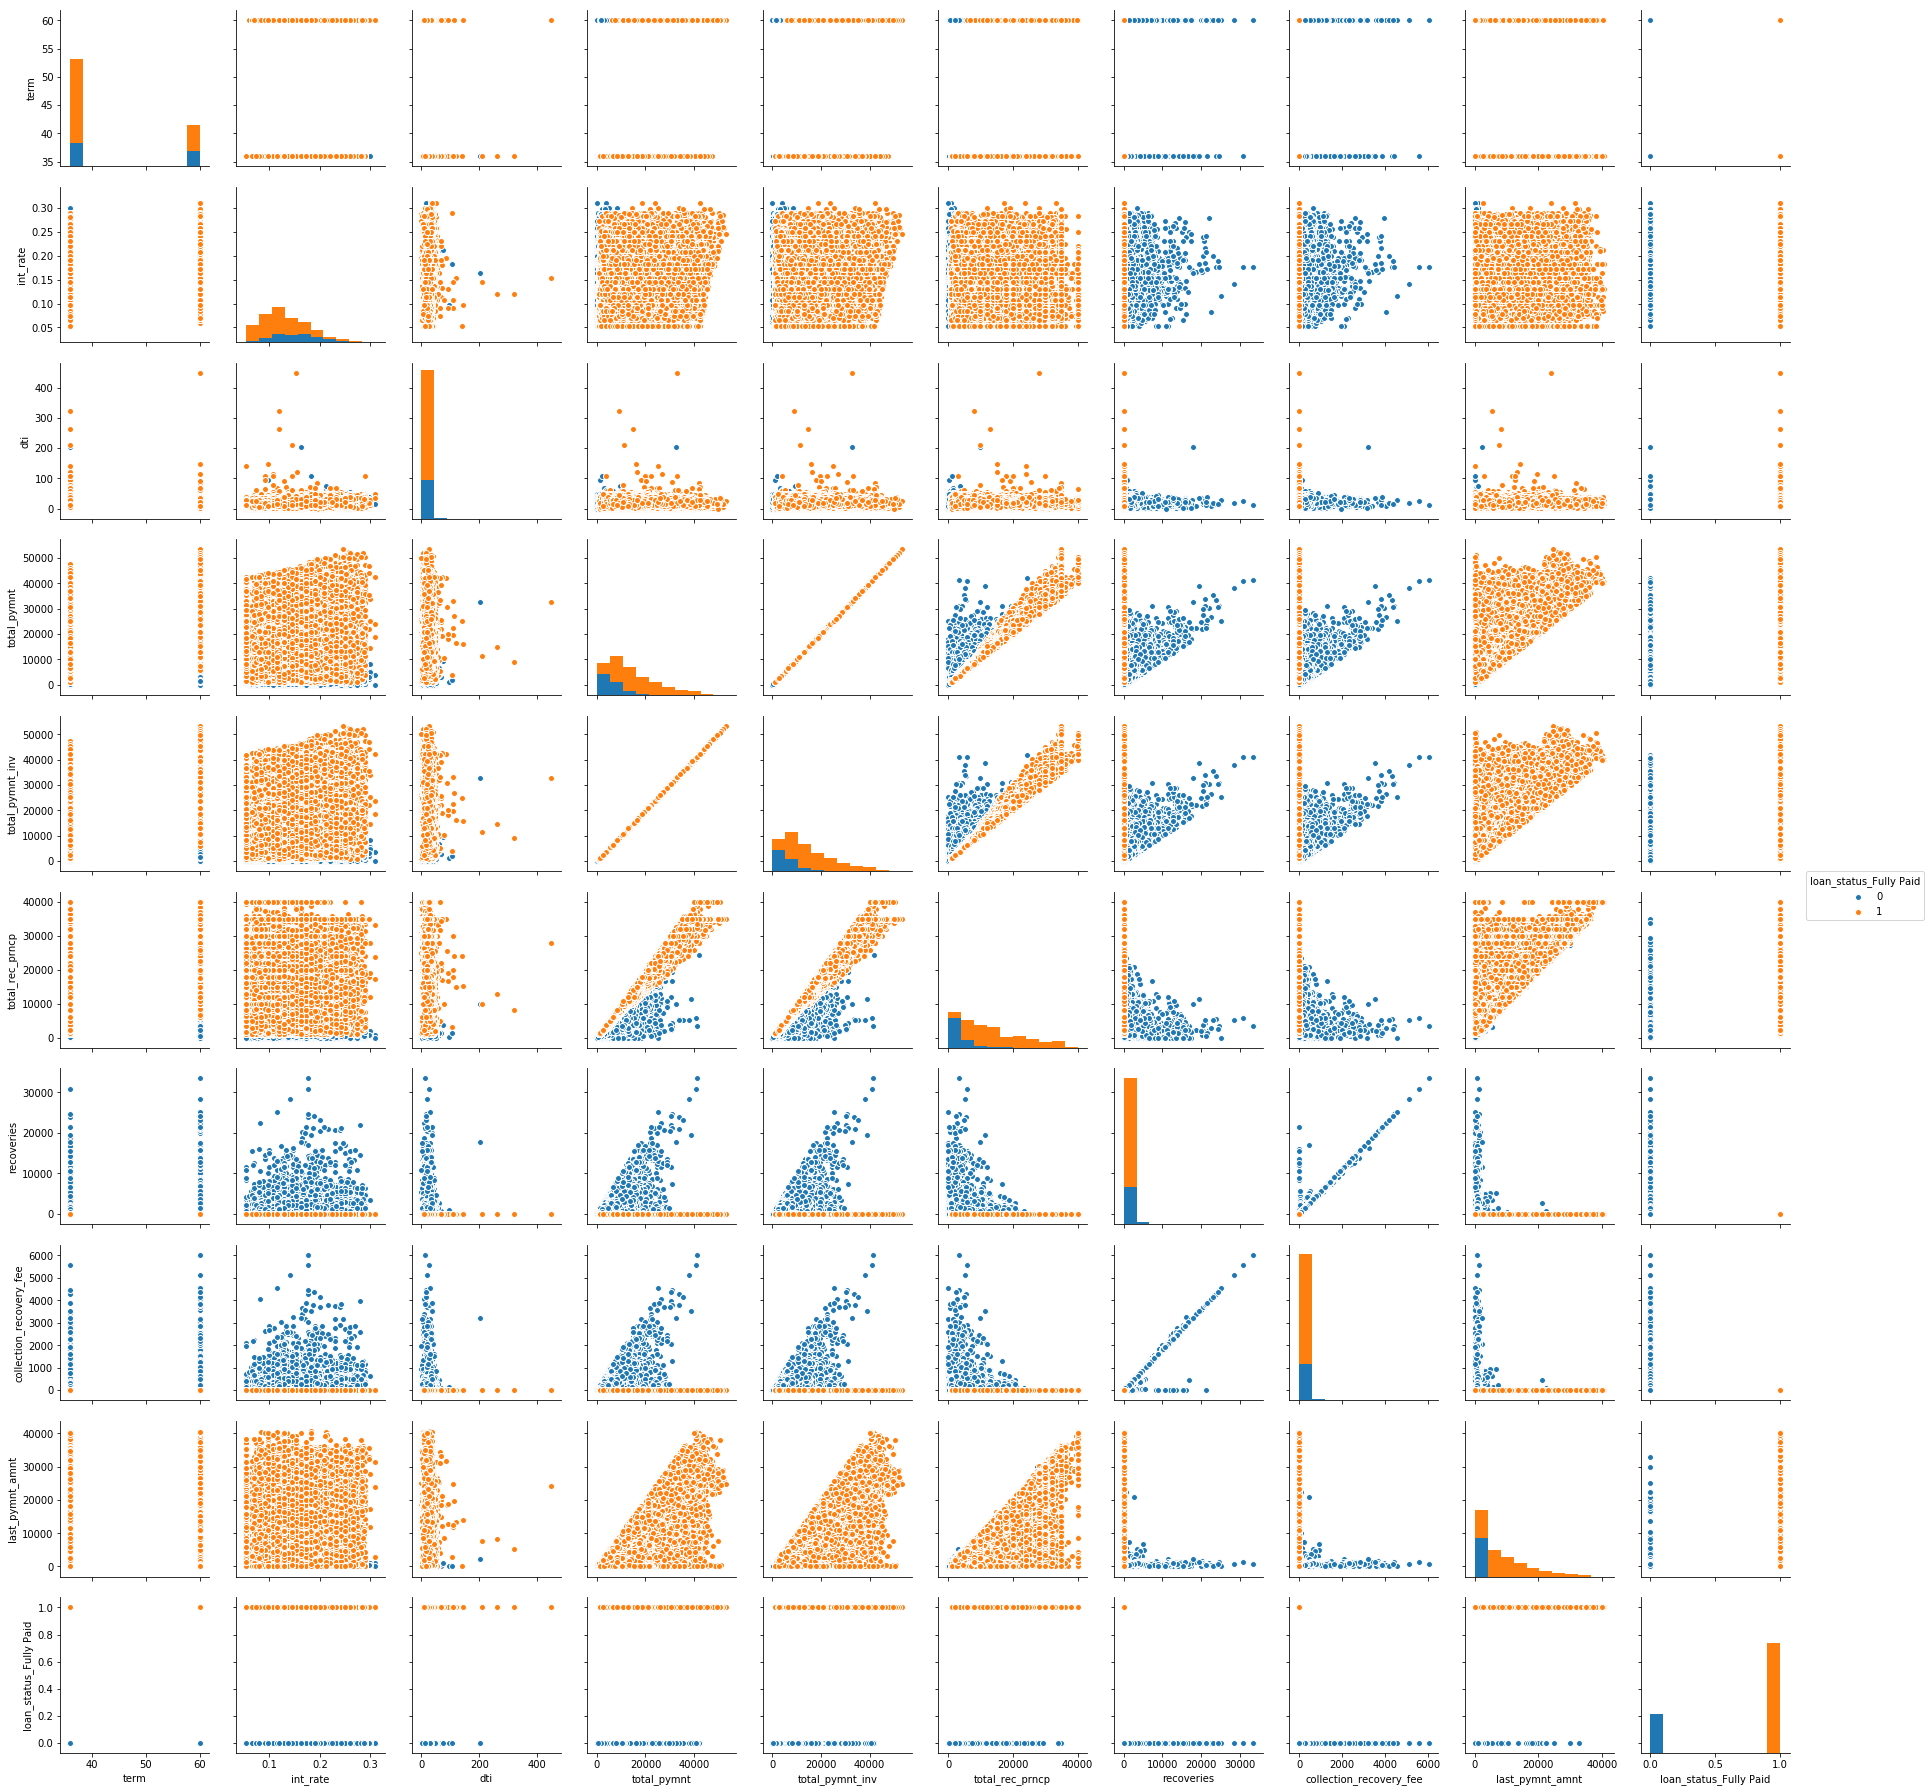

In [28]:
# This plots the pairwise combinations of variables
# color signifies default status (0=default, 1=fully paid) 
sns.pairplot(new_X[cols], hue="loan_status_Fully Paid")

In [29]:
# reclaim memory
new_X = None

## Modelling

### Imports, utility functions, standardizing, and train/test split

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

# KNN is not advised for samples >100k
# from sklearn.neighbors import KNeighborsClassifier

In [31]:
def pretty_metrics(x, y, clf):
    """
    This function prints a classification report and a confusion matrix
    which works by mapping 0 and 1 to their string counterparts and
    then using these to create a nice-looking confusion matrix.
    """
    
    y_true = pd.Series(["Fully paid" if t==1 else "Default" for t in y])
    y_pred = pd.Series(["Fully paid" if t==1 else "Default" for t in clf.predict(x)])
    
    cfm = pd.crosstab(y_true, y_pred, 
                     rownames=['Actual'], colnames=['Predicted'])
    
    print("\033[1mCurrent set performance\n\n")
    print("Classification report:\n\033[0m")
    print(classification_report(y, clf.predict(x)), end="\n\n")
    print("\033[1mConfusion matrix:\n\033[0m")
    
    display(cfm)

In [32]:
# Type-cast to float32 arrays
X_arr = X.values.astype(np.float32)
Y_arr = Y.values.astype(np.float32)

In [33]:
# Standardize and scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_arr)

In [34]:
# Set to 0.15 if using val
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y_arr, test_size=0.30, shuffle=True) 

# Validation split, if desired
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True)

### Logistic Regression

In [35]:
logr = LogisticRegression().fit(x_train, y_train)

In [36]:
train_score = logr.score(x_train, y_train)
test_score = logr.score(x_test, y_test)

print("Logistic Regression")
print(f"Training score:{train_score*100:.3f}%")
print(f"Test score:{test_score*100:.3f}%")

Logistic Regression
Training score:99.915%
Test score:99.891%


In [37]:
pretty_metrics(x_test, y_test, logr)

Current set performance


Classification report:

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     10756
        1.0       1.00      1.00      1.00     30355

avg / total       1.00      1.00      1.00     41111


Confusion matrix:



Predicted,Default,Fully paid
Actual,,
Default,10713,43
Fully paid,2,30353


### SVC classfier

In [38]:
svc = LinearSVC(C=5).fit(x_train, y_train)

In [39]:
train_score = svc.score(x_train, y_train)
test_score = svc.score(x_test, y_test)

print("Linear SVC")
print(f"Training score:{train_score*100:.3f}%")
print(f"Test score:{test_score*100:.3f}%")

Linear SVC
Training score:99.984%
Test score:99.978%


In [40]:
pretty_metrics(x_test, y_test, svc)

Current set performance


Classification report:

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     10756
        1.0       1.00      1.00      1.00     30355

avg / total       1.00      1.00      1.00     41111


Confusion matrix:



Predicted,Default,Fully paid
Actual,,
Default,10747,9
Fully paid,0,30355


### Decision Tree Classifier

In [41]:
dtc = DecisionTreeClassifier(min_samples_leaf=4, max_depth=10).fit(x_train, y_train)

In [42]:
train_score = dtc.score(x_train, y_train)
test_score = dtc.score(x_test, y_test)

print("Decision Tree classifier")
print(f"Training score:{train_score*100:.3f}%")
print(f"Test score:{test_score*100:.3f}%")

Decision Tree classifier
Training score:99.906%
Test score:99.793%


In [43]:
pretty_metrics(x_test, y_test, dtc)

Current set performance


Classification report:

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00     10756
        1.0       1.00      1.00      1.00     30355

avg / total       1.00      1.00      1.00     41111


Confusion matrix:



Predicted,Default,Fully paid
Actual,,
Default,10696,60
Fully paid,25,30330


### Random Forest Classifier

In [44]:
rfc = RandomForestClassifier(n_estimators=50,
                            max_depth=15, min_samples_leaf=4).fit(x_train, y_train)

In [45]:
train_score = rfc.score(x_train, y_train)
test_score = rfc.score(x_test, y_test)

print("Random Forest classifier")
print(f"Training score:{train_score*100:.3f}%")
print(f"Test score:{test_score*100:.3f}%")

Random Forest classifier
Training score:99.934%
Test score:99.820%


In [46]:
pretty_metrics(x_test, y_test, rfc)

Current set performance


Classification report:

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00     10756
        1.0       1.00      1.00      1.00     30355

avg / total       1.00      1.00      1.00     41111


Confusion matrix:



Predicted,Default,Fully paid
Actual,,
Default,10683,73
Fully paid,1,30354


### Voting model

Using the number of wrong predictions from each model I'm estimating weights to use for a voting classifier which may have lower accuracy but should perform better on unseen data.

In [47]:
y1 = svc.predict(x_test)
y2 = logr.predict(x_test)
y3 = rfc.predict(x_test)

misses1 = sum(y1 != y_test)
misses2 = sum(y2 != y_test)
misses3 = sum(y3 != y_test)

total_misses = misses1 + misses2 + misses3

weight1 = total_misses / misses1
weight2 = total_misses / misses2
weight3 = total_misses / misses3

total_weights = sum([weight1, weight2, weight3])

weight1 /= total_weights
weight2 /= total_weights
weight3 /= total_weights

# SVC, RFC, LogR
print("Weights:")
print("* SVC: {:.2f}%\n* LogR: {:.2f}%\n* RFC: {:.2f}%".format(weight1*100, weight2*100, weight3*100))

Weights:
* SVC: 75.66%
* LogR: 15.13%
* RFC: 9.20%


In [48]:
vc3 = VotingClassifier(estimators=[
       ('linear_svc', svc), ('logR', logr), ('rfc', rfc)],
       voting='hard', weights=[weight1, weight2, weight3],
       flatten_transform=True).fit(x_train, y_train)

In [49]:
train_score = vc3.score(x_train, y_train)
test_score = vc3.score(x_test, y_test)

print("Random Forest classifier")
print(f"Training score:{train_score*100:.3f}%")
print(f"Test score:{test_score*100:.3f}%")

C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Random Forest classifier
Training score:99.984%
Test score:99.978%


C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
pretty_metrics(x_test, y_test, vc3)

C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Current set performance


Classification report:

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     10756
        1.0       1.00      1.00      1.00     30355

avg / total       1.00      1.00      1.00     41111


Confusion matrix:



C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted,Default,Fully paid
Actual,,
Default,10747,9
Fully paid,0,30355


### Final model

Since the voting model has reached satisfactory performance we can now train on the whole dataset (train+val+test) and use that version to perform predictions.

In [51]:
final_model = vc3 = VotingClassifier(estimators=[
       ('linear_svc', svc), ('logR', logr), ('rfc', rfc)],
       voting='hard', weights=[weight1, weight2, weight3],
       flatten_transform=True).fit(X_scaled, Y_arr)

In [52]:
final_model_score = vc3.score(X_scaled, Y_arr)

print(f"Final score: {final_model_score*100:.3f}%")

Final score:99.986%


C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
pretty_metrics(X_scaled, Y_arr, final_model)

C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Current set performance


Classification report:

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     35690
        1.0       1.00      1.00      1.00    101345

avg / total       1.00      1.00      1.00    137035


Confusion matrix:



C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted,Default,Fully paid
Actual,,
Default,35671,19
Fully paid,0,101345


## Prediction

### Preprocess values

In [54]:
# Pick the current loans
current_loans = df[df["loan_status_Current"]==1]

# We need the same preprocessing steps here
current_loans.drop('next_pymnt_d', axis=1, inplace=True)
current_loans["mths_since_last_delinq"].fillna(np.mean(X["mths_since_last_delinq"]), inplace=True)
for column in np.sum(current_loans.isnull())[np.sum(current_loans.isnull()) > 0].keys():
    current_loans[column].fillna(np.mean(current_loans[column]), inplace=True)

# keep only the X columns 
current_loans = current_loans[[x for x in current_loans.columns if not x.startswith('loan_status')]]
current_loans.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,...,title_new day,title_new kitchen for momma!,title_odymeds,initial_list_status_f,initial_list_status_w,application_type_DIRECT_PAY,application_type_INDIVIDUAL,application_type_JOINT,hardship_flag_N,hardship_flag_Y
2,7200,36,0.1148,237.36,10.0,72500.0,42339,8.47,0,38200,...,0,0,0,0,1,0,1,0,1,0
3,21875,36,0.1199,726.46,0.5,47590.0,42339,17.76,0,36982,...,0,0,0,0,1,0,1,0,1,0
4,20000,36,0.1288,672.73,10.0,145000.0,42339,12.28,0,38018,...,0,0,0,0,1,0,1,0,1,0
5,28000,36,0.1344,949.38,2.0,125000.0,42339,7.49,0,36647,...,0,0,0,0,1,0,1,0,1,0
8,10000,60,0.1797,253.78,2.0,55000.0,42339,35.70,0,36982,...,0,0,0,0,1,0,1,0,1,0


In [55]:
# Convert to array
current_arr = current_loans.values.astype(np.float32)

# Standardize
current_scaled = scaler.transform(current_arr)

### Predict values

In [56]:
predictions = final_model.predict(current_scaled)
predictions

C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

### Final steps

Get predictions for the training data and add them to the original excel file. The `X` and `current_loans` dataframes have preserved the original indices so concatenating them will preserve the correct mappings.

In [57]:
current_loans["Model predictions"] = predictions

In [58]:
X["Model predictions"] = final_model.predict(X_arr)

C:\Users\Konstantinos\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
# These are not ordered but have kept their indices
merged = pd.concat([X, current_loans])
merged.head()

# Reclaim memory
X = None
X_arr = None
current_loans = None
X_scaled = None

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,...,title_new kitchen for momma!,title_odymeds,initial_list_status_f,initial_list_status_w,application_type_DIRECT_PAY,application_type_INDIVIDUAL,application_type_JOINT,hardship_flag_N,hardship_flag_Y,Model predictions
0,25000,36,0.0749,777.55,10.0,109000.0,42339,26.02,0,37226,...,0,0,0,1,0,1,0,1,0,1.0
1,23975,60,0.1989,633.73,10.0,70000.0,42339,33.20,0,34851,...,0,0,0,1,0,1,0,1,0,0.0
6,20000,36,0.0980,643.47,5.0,75000.0,42339,23.45,0,33725,...,0,0,0,1,0,1,0,1,0,1.0
7,15000,60,0.1344,344.69,4.0,77213.0,42339,18.17,0,37226,...,0,0,0,1,0,1,0,1,0,1.0
9,15000,36,0.0849,473.45,6.0,110000.0,42339,13.24,0,37591,...,0,0,0,1,0,1,0,1,0,1.0


In [60]:
# Overwrite old df to free memory
df = pd.read_excel("LoadData15_16.xlsx")

In [61]:
# Write the new column
df["Model predictions"] = merged["Model predictions"]

# Reclaim memory
merged = None

Finally, we save the data with the extra `predictions` column:

In [62]:
df.to_excel("FinalData.xlsx")